# Predicting Wine Quality

---
embed-resources: true
---

## Introduction

For this model, we have used chemistry equipment to get data from wine. The model here predicts the quality of wine from a scale of 1-10 where 1 is very bad wine and 10 being very high quality wine. This model is only applicable to the wine in the dataset and not all wine. 

## Methods

In [26]:
# imports
# basic imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump

# machine learning imports
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# preprocessing imports
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error

### Data

In [27]:
# load data
wine_train = pd.read_parquet(
    "https://cs307.org/lab/data/wine-train.parquet",
)
wine_test = pd.read_parquet(
    "https://cs307.org/lab/data/wine-test.parquet",
)
wine_train

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
2556,7.6,0.23,0.64,12.9,0.033,54.0,170.0,0.99800,3.00,0.53,8.8,5,white
1237,NaN,0.75,0.01,2.2,0.059,11.0,18.0,0.99242,3.39,0.40,NaN,6,red
303,7.4,0.67,0.12,1.6,0.186,5.0,21.0,0.99600,3.39,0.54,9.5,5,red
1583,6.4,0.18,0.74,NaN,0.046,54.0,168.0,0.99780,3.58,0.68,10.1,5,white
4697,6.7,0.35,0.32,9.0,0.032,29.0,113.0,0.99188,3.13,0.65,12.9,7,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013,6.6,0.32,0.22,16.7,0.046,38.0,133.0,0.99790,3.22,0.67,10.4,6,white
905,9.2,0.58,0.20,3.0,0.081,15.0,115.0,0.99800,3.23,0.59,9.5,5,red
247,8.2,0.60,0.17,2.3,0.072,11.0,73.0,0.99630,3.20,0.45,9.3,5,red
2707,6.5,0.23,0.36,16.3,0.038,43.0,133.0,0.99924,3.26,0.41,8.8,5,white


The variables in this dataset are:
### Response 

**`Quality`**

- [int64] the quality of the wine based on evaluation by a minimum of three sensory assessors (using blind tastes), which graded the wine in a scale that ranges from 0 (very bad) to 10 (excellent)


### Features

**`Color`**

- [object] the (human perceivable) color of the wine, red or white

**`fixed acidity`**

- [float64] grams of tartaric acid per cubic decimeter

**`volatile acidity`**

- [float64] grams of acetic acid per cubic decimeter

**`citric acid`**

- [float64] grams of citric acid per cubic decimeter

**`residual sugar`**

- [float64] grams of residual sugar per cubic decimeter

**`chlorides`**

-[float64] grams of sodium chloride cubic decimeter

**`free sulfur dioxide`** 

- [float64] milligrams of free sulfur dioxide per cubic decimeter

**`total sulfur dioxide`** 

- [float64] milligrams of total sulfur dioxide per cubic decimeter

**`density`** 

- [float64] the total density of the wine in grams per cubic centimeter

**`pH`** 

- [float64] the acidity of the wine measured using pH

**`sulphates`** 

- [float64] grams of potassium sulphate cubic decimeter

**`alcohol`** 

- [float64] percent alcohol by volume

For our summary statistics, we have 4157 different kinds of wine and its 12 features.

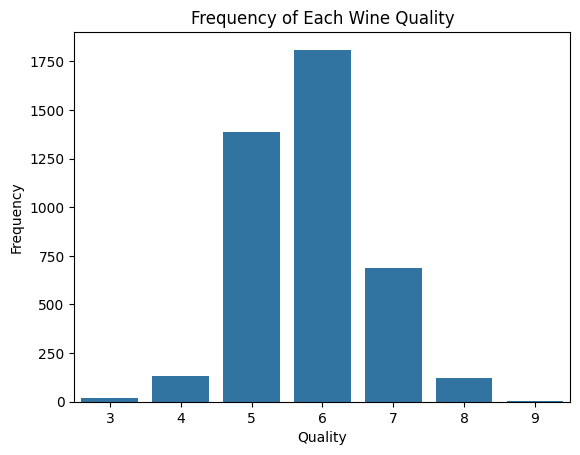

In [28]:
sns.countplot(x='quality', data=wine_train)
plt.title('Frequency of Each Wine Quality')
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.show()


The bar plot above shows the quality of each wine is distributed and what quality numbers come up the most and least.

### Models

In [29]:
# process data for ML
# create X and y for train
X_train = wine_train.drop("quality", axis=1)
y_train = wine_train["quality"]

# create X and y for test
X_test = wine_test.drop("quality", axis=1)
y_test = wine_test["quality"]

numeric = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
           'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
categorical = ['color']
features = numeric + categorical
target = 'quality'

We must first separate the train and test sets for testing on the train data first. Then, we split the features whether if it is numeric or categorical. In this case, our target variable is the quality of the wine.

In [30]:
numeric_transformer = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler(),
)

# define preprocessing for categorical features
categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant"),
    OneHotEncoder(handle_unknown="infrequent_if_exist"),
)

# create general preprocessor
preprocessor = make_column_transformer(
    (numeric_transformer, numeric),
    (categorical_transformer, categorical),
    remainder="drop",
)

In [31]:
model = KNeighborsClassifier()
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'model__n_neighbors': [1, 5, 10, 15, 20, 25, 50],  
    'model__weights': ['uniform', 'distance'],  
    'model__p': [1, 2]  
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5, 
    scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best model after grid search
best_model = grid_search.best_estimator_

/Users/danielkim/Desktop/cs 307/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


The pipeline and the grid search allows the KNeighborsClassifier model to try different settings, find the best k_neighbors value, and combine these factors together to come up with the best trained model to use.

## Results

In [32]:
# report model metrics
y_test_pred = best_model.predict(X_test)

# Calculate MAE on the test set
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mae

0.4125

When using our best model to use on the test data, we are able to get a mean_absolute_error score of 0.4125. This means that our best model is 0.4125 values away from the actual quality of a wine on average.

In [33]:
# serialize model
dump(best_model, 'wine.joblib')

['wine.joblib']

## Discussion

Our final model achieves a test MAE score of 0.4125 and accomplishes of outperforming a test MAE of 0.5. The MAE value represents the average error from the actual value. This MAE score of 0.4125 means that when our model is trying to predict the quality of a wine based on its characteristics, on average the predictions will be off by 0.4125 from the actual quality of a wine.

Since the wine quality scale ranges from a scale of 1-10, a MAE of 0.4125 is pretty small. However, I believe we should use this model depending on the situation. For example, if we are using this model for very precise predictions, such as determining the price of a wine, we should not use it. Doing this could predict a wine with a true quality score of 6 either to fall down to a score of 5.5875 which would underprice the wine and lose profit. It can also score it too high at a 6.4125 and overprice the wine which could affect sales. But when using it for something simple such as suggesting wine to customers, this should be sufficient since the stakes aren't too high and the error is low.

In order to further improve this model, we could test out which features are big factors that determine the quality of a wine and get rid of the factors that have little to no effect on the quality. Another way is to collect more samples of wine so that the model is able to learn better.

The correlation matrix below shows each numeric factor and its correlation to the quality of the wine. We can see that almost all of the features have a very weak correlation with quality except for alcohol. For future model making, we should take out the features with weak correlations with the quality so that the model will be able to predict the quality more accurately and also gather more data from more different kinds of wine.

In conclusion, we should not use this model for high precision tasks but can be used for general purposes. 

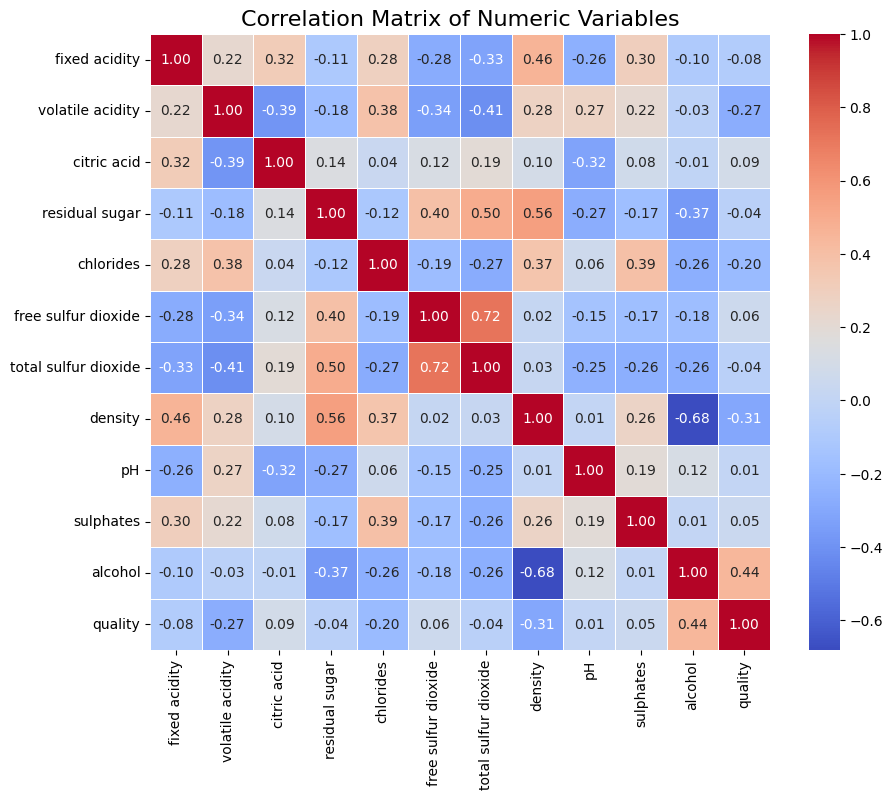

In [34]:
# exploratory visualization
numeric = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
           'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']
corr = wine_train[numeric].corr()
plt.figure(figsize=(10, 8))  
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Variables', fontsize=16)
plt.show()